*ASSIGNMENT 2: Using the pre-processed dataset (from assignment 1), this assignment requires you to prepare the training and validation data subsets for subsequent ML-based classification tasks. The tasks that you need to perform are given below. See instructions for completing and submitting the assignment.*

# Instructions
*   After uploading the notebook to your Google Drive, **Please add your Banner ID to the end of the file name**. So, the file name should look like "Assignment_2_B00123456.ipynb"
*   Please complete the required sections by adding as many code cells as you want to each section.
*   The only libraries that you may use are **NumPy, Pandas, Scikit-learn, matplotlib**.
*   You can use the material from the tutorials. Feel free to use any other methods or classes from the mentioned libraries that you think are suitable.
*   After finishing your work, please **run all the cells**, download the notebook (**.ipynb format**) and email it to **jaber.rad@dal.ca (also cc ssrabidi@dal.ca)**.
*   Please feel free to discuss any issues in the Teams channel.
*   **Good luck!**


---



# TASK 1. Prepare the data


*   Include all the required code cells from assignment 1 and apply any changes that you think are necessary.
*   Explain what changes you made to the code from assignment 1, and what was the purpose/need of these changes, if any.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

drive.mount('/content/drive')
path = "/content/drive/My Drive/Colab Notebooks/HINF6210/data/Dataset_Jack.csv"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0) # set seed now since we are randomizing with splitting

data = pd.read_csv(path, na_values='?') # specify that ? are missing  

In [ ]:
# clean names
data.columns=data.columns.str.lower().str.replace(' ','_')

data = data.replace({'t': True, 'f': False, 'M': True, 'F': False}) 
# turn strings into a boolean
# male = T, female = F, doing this to maintain any missing values 

# rename because we turned sex into a boolean
data = data.rename(columns={"sex": "sex_male"}) # more informative name

# dummy code referral_source
data = pd.get_dummies(data, columns = ['referral_source'])
# apply name cleaning again
data.columns=data.columns.str.lower().str.replace(' ','_')

# convert columns to appropriate data type
data=data.convert_dtypes()

# replace pandas NAs with numpy NaNs
data = data.replace(pd.NA, np.nan)

# clean and create target
data[['target','class_number']] = data['class'].str.split(".", expand=True)
data['class_number'] = data['class_number'].str.replace('|','')
# code target to 1/0
data['target'] = np.where(data['target'] == "negative", 0, 1)
# convert target to boolean
data=data.convert_dtypes()

# remove some uneeded columns
data=data.drop(['class', 'class_number', 'tbg', 'tbg_measured'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


##Impute

It's possible that having too many iterations in the `IterativeImpute` will bias the estimations of missing. We will evaluate the accuracy of a random forest classifier across 1 to 10 iterations.

>1 0.994 (0.005)
>2 0.995 (0.004)
>3 0.995 (0.004)
>4 0.996 (0.003)
>5 0.995 (0.004)
>6 0.993 (0.005)
>7 0.994 (0.004)
>8 0.994 (0.004)
>9 0.996 (0.004)
>10 0.994 (0.004)


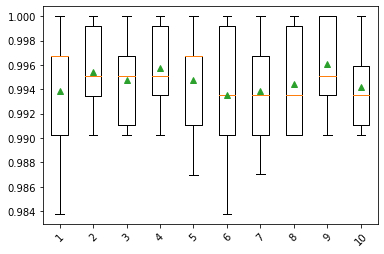

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# separate to target and inputs
y = data['target'].astype(int) # target
X = data.drop(['target'], axis=1) # inputs

# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in range(1, 11)] # max of 10 iterations
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(
      steps=[('i', IterativeImputer(max_iter=int(s),
                                    random_state=0,
                                    n_nearest_features=None, 
                                    sample_posterior=True))), 
             ('m', RandomForestClassifier())]
      )
	# evaluate the model
	cv = StratifiedKFold(n_splits=10, shuffle = True, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
 
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

It seems like the accuracy is generally the same across 1 to 10 interations, so I'll choose `4` iterations since the standard deviation seems the lowest and the accuracy is highest.

I will apply a similar strategy for the `n_nearest_features` parameter. Evaluating accuracy between 1 to 5 nearest features. It looks like they are all similar in terms of accuracy, so I will choose `3` nearest features as the accuracy is the highest and the standard deviation is also the lowest.

>1 0.994 (0.005)
>2 0.994 (0.003)
>3 0.995 (0.004)
>4 0.994 (0.004)
>5 0.994 (0.004)


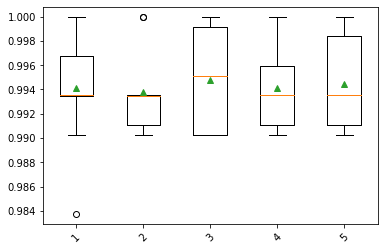

In [ ]:
# evaluate each strategy on the dataset
results = list()
strategies = [str(i) for i in range(1, 6)] # max of 10 iterations
for s in strategies:
	# create the modeling pipeline
	pipeline = Pipeline(
      steps=[('i', IterativeImputer(max_iter=2,  # based on above analysis
                                    random_state=0,
                                    n_nearest_features=int(s), 
                                    sample_posterior=True)), 
             ('m', RandomForestClassifier())]
      )
	# evaluate the model
	cv = StratifiedKFold(n_splits=10, shuffle = True, random_state=1)
	scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# store results
	results.append(scores)
	print('>%s %.3f (%.3f)' % (s, mean(scores), std(scores)))
 
# plot model performance for comparison
pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

my_imputer = IterativeImputer(
  missing_values=np.nan, # specify missing here to make sure we use np NaNs
  random_state=3, # keep random number generator as 0
  n_nearest_features=3, # due to analysis above
  max_iter=2, # changed from 1 to 2 based on the analysis above
  sample_posterior=True, # need to set to true for this iterative imputer to work
)

imputed_data = pd.DataFrame(
  my_imputer.fit_transform(data), # impute
  columns = data.columns # specify column names as it returns numbers
)

imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3076 non-null   float64
 1   sex_male                   3076 non-null   float64
 2   on_thyroxine               3076 non-null   float64
 3   query_on_thyroxine         3076 non-null   float64
 4   on_antithyroid_medication  3076 non-null   float64
 5   sick                       3076 non-null   float64
 6   pregnant                   3076 non-null   float64
 7   thyroid_surgery            3076 non-null   float64
 8   i131_treatment             3076 non-null   float64
 9   query_hypothyroid          3076 non-null   float64
 10  query_hyperthyroid         3076 non-null   float64
 11  lithium                    3076 non-null   float64
 12  goitre                     3076 non-null   float64
 13  tumor                      3076 non-null   float

It looks like imputation changed all the data into `float64` so before doing any more analysis, we should change the data types

In [ ]:
imputed_data=imputed_data.convert_dtypes()
imputed_data['target'] = imputed_data['target'].astype(bool) # so that kfold strat will work
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3076 entries, 0 to 3075
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3076 non-null   Float64
 1   sex_male                   3076 non-null   Float64
 2   on_thyroxine               3076 non-null   Int64  
 3   query_on_thyroxine         3076 non-null   Int64  
 4   on_antithyroid_medication  3076 non-null   Int64  
 5   sick                       3076 non-null   Int64  
 6   pregnant                   3076 non-null   Int64  
 7   thyroid_surgery            3076 non-null   Int64  
 8   i131_treatment             3076 non-null   Int64  
 9   query_hypothyroid          3076 non-null   Int64  
 10  query_hyperthyroid         3076 non-null   Int64  
 11  lithium                    3076 non-null   Int64  
 12  goitre                     3076 non-null   Int64  
 13  tumor                      3076 non-null   Int64

# TASK 2. Split the data using train_test_split


*   Use default values for the shuffle and stratify parameters.
*   Consider 20% of the data as the validation subset.

In [ ]:
from sklearn.model_selection import train_test_split

train_2, test_2 = train_test_split(
  imputed_data, 
  train_size=0.8, 
  test_size=None,
  random_state=10
)

# TASK 3. Stratify the data splitting


*   Set the stratify parameter to the target column.
*   Consider 20% of the data as the validation subset.

In [ ]:
train_3, test_3 = train_test_split(
  imputed_data, 
  train_size=0.8, 
  test_size=None,
  random_state=10,
  shuffle=True,
  stratify=imputed_data['target']
)

# TASK 4. Plot chart(s) to show the number of instances in each data subset from each class


*   Visualize the distribution of the target values in each data subset obtained from task 2 and task 3. You can either plot one chart for both tasks or plot separate charts for each task.
*   Compare the charts and explain the salient differences.

## Comparing training sets

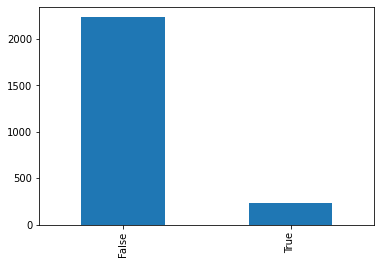

In [ ]:
import matplotlib.pyplot as plt

train_2['target'].value_counts().plot(kind='bar');

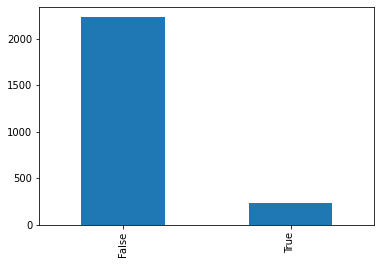

In [ ]:
train_3['target'].value_counts().plot(kind='bar');

In [ ]:
train_2['target'].value_counts()

False    2233
True      227
Name: target, dtype: int64

In [ ]:
train_3['target'].value_counts()

False    2227
True      233
Name: target, dtype: int64

Stratifying the sample did not make much of a difference in the distribution of the `target` variable because the non-stratified sample seemed to be similar to the original proportions already. As such, the plots look very similar.

This can be seen similarly in the test splits shown in the value counts below (I think it's quicker and more informative in this case than plots)

In [ ]:
test_2['target'].value_counts()

False    552
True      64
Name: target, dtype: int64

In [ ]:
test_3['target'].value_counts()

False    558
True      58
Name: target, dtype: int64

# TASK 5. K-fold Cross Validation

* From this [link](https://scikit-learn.org/stable/modules/cross_validation.html), pick the right cross-validation iterator and apply it to your training subset. 
* Set the number of splits to 5 and if it is necessary to set the test size, set it to 10%.
* Using a loop and the split method of the cross-validation iterator class, print the instances in all the cross-validation iterations.

In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold

# need to turn dataframe to array for the CV functions
X = train_3.drop(['target'], axis=1).values # inputs 
y = train_3.loc[:,'target'].values # target

print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2460, 31) and shape of target variable: (2460,)


Data looks ready to go into CV. 31 features in total

Stratified K fold is probably best as we want to preserve the same percentage of samples of each target class in each of the 5 folds. This will make future models fit better to the data.

In [18]:
# now using stratified k fold, with 5 splits, and use random generator as 0 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

cnt = 0
for train_index, test_index in skf.split(X, y):
  cnt+=1
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  print("Instance:", cnt) # prints each instance
  print('Inputs:')
  print(X_train)
  print('Target:', y_train)
  print('')
    

Instance: 1
Inputs:
[[43.0 0.0 0 ... 0 0 1]
 [62.0 0.0 0 ... 0 0 1]
 [46.0 1.0 0 ... 0 0 1]
 ...
 [41.0 0.0 0 ... 0 0 1]
 [18.0 0.0 0 ... 0 0 1]
 [41.0 0.0 0 ... 0 0 1]]
Target: [False False False ... False False False]

Instance: 2
Inputs:
[[43.0 0.0 0 ... 0 0 1]
 [62.0 0.0 0 ... 0 0 1]
 [61.0 0.0 0 ... 0 0 1]
 ...
 [67.0 1.0 0 ... 0 1 0]
 [38.0 0.0 0 ... 0 0 1]
 [41.0 0.0 0 ... 0 0 1]]
Target: [False False False ... False False False]

Instance: 3
Inputs:
[[62.0 0.0 0 ... 0 0 1]
 [61.0 0.0 0 ... 0 0 1]
 [46.0 1.0 0 ... 0 0 1]
 ...
 [41.0 0.0 0 ... 0 0 1]
 [18.0 0.0 0 ... 0 0 1]
 [41.0 0.0 0 ... 0 0 1]]
Target: [False False False ... False False False]

Instance: 4
Inputs:
[[43.0 0.0 0 ... 0 0 1]
 [62.0 0.0 0 ... 0 0 1]
 [61.0 0.0 0 ... 0 0 1]
 ...
 [67.0 1.0 0 ... 0 1 0]
 [41.0 0.0 0 ... 0 0 1]
 [18.0 0.0 0 ... 0 0 1]]
Target: [False False False ... False False False]

Instance: 5
Inputs:
[[43.0 0.0 0 ... 0 0 1]
 [61.0 0.0 0 ... 0 0 1]
 [46.0 1.0 0 ... 0 0 1]
 ...
 [41.0 0.0 0 ... 0 

From viewing the printed instance, we can already see that each of the 5 splits are different from each other.

*The end!*